In [1]:
# Common imports

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Torch has to go first due to an importing bug
import torch

import collections

import numpy as np
import scipy.io
import scipy.ndimage

import PIL

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision


In [3]:
import os
os.environ['PYTORCH_DATA_PATH'] = 'C:\\users\\opera_user\\Anaconda3\\Lib\\site-packages\\torchvision\\datasets'
os.environ['TORCH_MODEL_ZOO'] =  os.environ['PYTORCH_DATA_PATH']


In [4]:
CUDA = False

def to_np(x):
    if isinstance(x, Variable):
        x = x.data
    return x.cpu().numpy()

def to_variable(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return Variable(x, **kwargs)

In [23]:
??vgg

# Info:

- [VGG network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) 
- [Imagenet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012)](http://image-net.org/challenges/LSVRC/2012/)
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

I investigate how VGG classifies images, and 
try to build a deeper understanding of which parts of
a particular input image influence the output of the network.
We will start by simply occluding parts of the image
with a square of zeros anchored at point $(i, j)$ ,
and analyzing how the signal propagated through the network changes.
Becuase pre-processing for VGG requires to subtract the mean,
the most neutral occluding squares will appear grey when pre-processing is reversed.
Further reading: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)

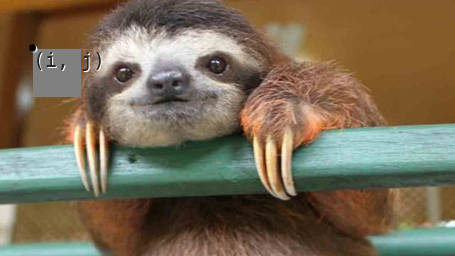

[Integrated Gradients](https://arxiv.org/abs/1703.01365)

In [5]:
class ILSVRC2014Sample(object):
    """Mapper from numerical class IDs to their string LABELS and DESCRIPTIONS.
    
    Please use the dicts:
    - id_to_label and label_to_id to convert string labels and numerical ids
    - label_to_desc to get a textual description of a class label
    - id_to_desc to directly get descriptions for numerical IDs
    
    """
    def load_image(self, path):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        for t in self.transforms:
            img = t(img)
        return numpy.asarray(img).astype('float32') / 255.0
    
    def __init__(self, num=100):
        self.transforms = [
            torchvision.transforms.Scale(256),
            torchvision.transforms.CenterCrop(224)]
        
        base_dir = os.environ['PYTORCH_DATA_PATH'] + '/ILSVRC2014'
        devkit_dir = base_dir + '/ILSVRC2012_devkit_t12/data'
        
        meta = scipy.io.loadmat(devkit_dir + '/meta.mat')
        imagenet_class_names = []
        self.label_to_desc = {}
        for i in range(1000):
            self.label_to_desc[meta['synsets'][i][0][1][0]] = meta['synsets'][i][0][2][0]
            imagenet_class_names.append(meta['synsets'][i][0][1][0])
        
        img_names = sorted(os.listdir(base_dir + '/ILSVRC2012_img_val'))[:num]
        img_ids = {int(re.search('\d{8}', name).group()) for name in img_names}
        with open(devkit_dir + '/ILSVRC2012_validation_ground_truth.txt', 'r') as f:
            self.labels = [imagenet_class_names[int(line.strip()) - 1] \
                           for i, line in enumerate(f) if i+1 in img_ids]
        self.data = [self.load_image(base_dir + '/ILSVRC2012_img_val/' + name)
                     for name in img_names]
        
        self.id_to_label = sorted(self.label_to_desc.keys())
        self.label_to_id = {}
        self.id_to_desc = []
        for id_, label in enumerate(self.id_to_label):
            self.label_to_id[label] = id_
            self.id_to_desc.append(self.label_to_desc[label])

In [91]:
class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x


class VGG(torch.nn.Module):
    """Wrapper around a VGG network allowing convenient extraction of layer activations.
    
    """
    FEATURE_LAYER_NAMES = {
        'vgg16':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1"
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2"
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "pool3"
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3",
             "relu4_3", "pool4"
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3",
             "relu5_3", "pool5"],
        'vgg19':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "conv3_4", "relu3_4", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2",
             "conv4_3", "relu4_3", "conv4_4", "relu4_4", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2",
             "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5"]}
    
    def __init__(self, model='vgg19'):
        super(VGG, self).__init__()
        all_models = {'vgg16': torchvision.models.vgg16,
                      'vgg19': torchvision.models.vgg19}   
        vgg = all_models[model](pretrained=True)
        
        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax()
        
        self.feature_names = self.FEATURE_LAYER_NAMES[model]
        
        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def probabilities(self, x):
        """Return class probabilities.
        """
        #1/(1+exp(-logit))
        logits = self.softmax(self.forward(x))
        #prob = 1./(1.+torch.exp(-logits))
        #prob / torch.sum(prob)
        return logits
        
    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError('Layer %s not found' % layer_name)
    
    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
        layers_x = dict()
        layers_list=[]
        x = self.preprocess(x)
        
        for name, layer in list(zip(self.feature_names, self.features)):
            x = layer(x)
            if name in layer_names:
                layers_x[name] = x
        
        for i in layer_names:
            #print(i)
            layers_list.append(layers_x[i])
        
        return layers_list
        raise ValueError('Layer %s not found' % layer_name)



    def predict(self, x):
        """Return predicted class IDs.
        """
        logits = self(x)
        values, ind = torch.max(logits, 1)
        return ind
    
vgg = VGG('vgg19')

if CUDA:
    vgg.cuda()

In [35]:
# List layers in the model
print ('Feature layers')
print ('--------------')
for name, layer in zip(vgg.feature_names, vgg.features):
    print ('{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1)))
print ('\nClassifier layers')
print ('-----------------')
for layer in vgg.classifier:
    print ('{: <12}({}'.format(*str(layer).split('(', 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_3   (inplace)
Conv2d      

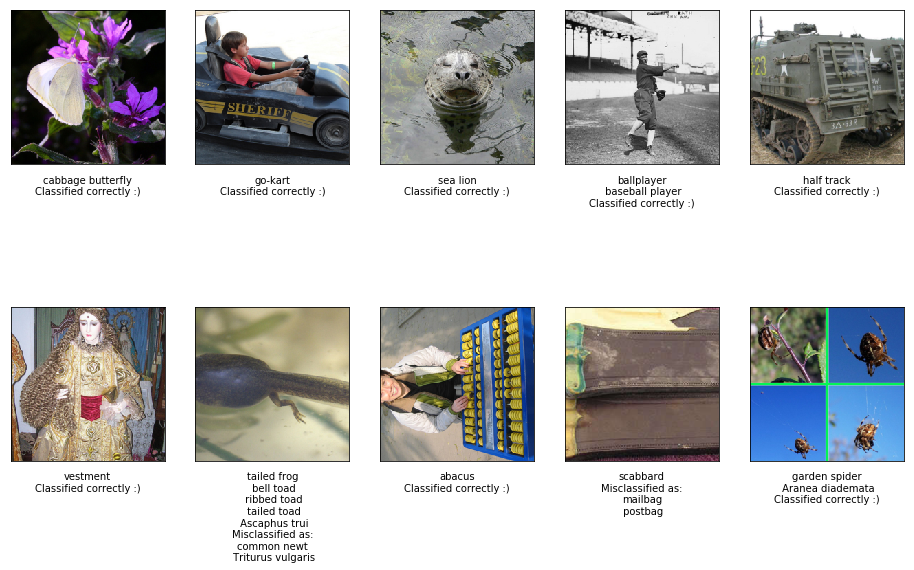

In [22]:
import re
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_variable(img, volatile=True)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ilsvrc.label_to_desc[label].split(',')
    if label == predicted_label:
        desc.append('Classified correctly :)')
    else:
        desc.append('Misclassified as:')
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(','))
    
    ax = subplot(2, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    imshow(img)

# Classification of my images below


88.0
12.0
7.0
72.0
98.0


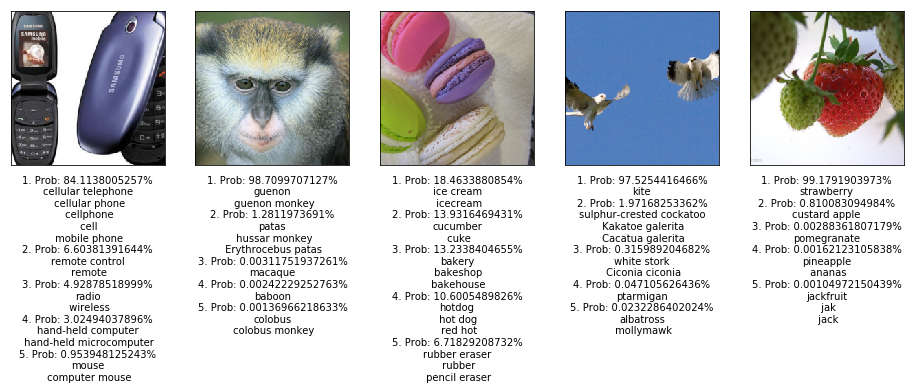

In [669]:
rand_num = 100
ilsvrc = ILSVRC2014Sample(rand_num)
vgg.eval()
a = np.floor(np.random.uniform(0, rand_num,size = 5))
figsize(16, 10)
for i in range(5):
    print(a[i])
    img = ilsvrc.data[int(a[i])]
    label = ilsvrc.labels[int(a[i])]

    img_torch = to_variable(img, volatile=True)
    probs = to_np(vgg.probabilities(img_torch))
    
    most_prob_labels_id = np.argsort(-probs).flatten()[:5]
 
    most_prob_labels = []
    most_prob_labels_desc=[]
    top_results = []
    for k, j in enumerate(most_prob_labels_id):
        most_prob_labels.append(ilsvrc.id_to_label[j])
        most_prob_labels_desc.append(ilsvrc.label_to_desc[most_prob_labels[k]].split(','))
        top_results.append(100*probs[0][j])

        
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    #desc = ilsvrc.label_to_desc[label].split(',')
    desc = []
    #if label == predicted_label:
        #desc.append('Classified correctly :)')
    #else:
        #desc.append('Misclassified as:')
    for k, j in enumerate(most_prob_labels_desc):
        desc.append(str(k+1)+'. Prob: '+str(top_results[k])+'%')
        desc.extend(j)
    ax = subplot(2, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    imshow(img)

## Analyse the responses of the network when part of the input is obscured

In [23]:
def obscured_imgs(img, boxsize=8, bsz=64, stride=4):
    list_img = []
    list_img.append(img.copy())
    count = 1
    grey = 0.5
    num = int(len(img)/(stride)-1)
    for row in range(num):
        for col in range(num):
            #print(count)
            #print(row,col*stride, col*stride+boxsize)
            for k in range(boxsize):        
                list_img[count-1][k+row*stride][col*stride:col*stride+boxsize] = grey
            count +=1
            if count>bsz:
                #print(len(list_img))
                return tuple(list_img)
            else:
                list_img.append(img.copy())
#zrobic jedynie tak zeby zwracal tuple? i dzialal na kopii?    

In [6]:
import plotting1 as plotting

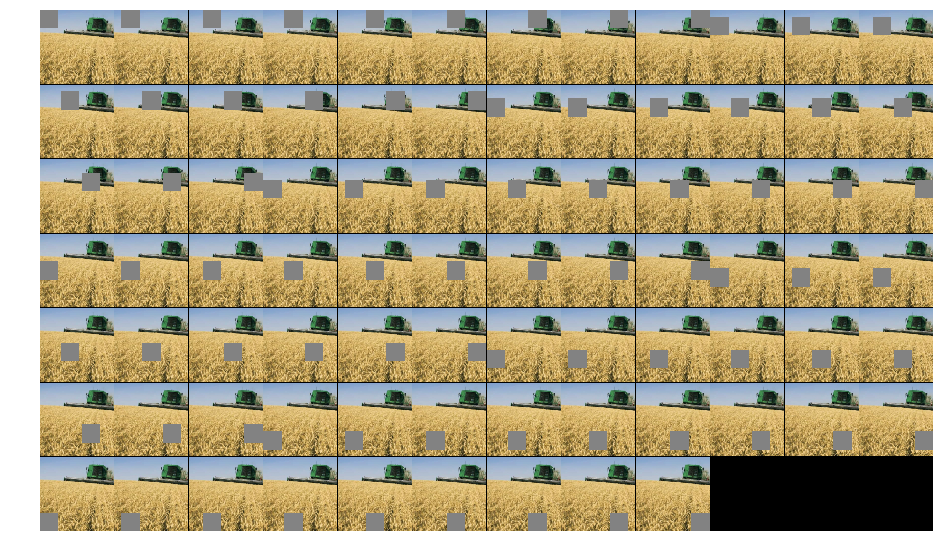

In [24]:
batch = obscured_imgs(ilsvrc.data[14],boxsize=56, bsz=81, stride=21)
batch = np.vstack([im[None] for im in batch])

plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [25]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [26]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx]
target = 0
desc = ilsvrc.label_to_desc[label]
for i, j in enumerate(ilsvrc.id_to_desc):
    if(j == desc):
        target = i

# if you run out of GPU mem split batch into smaller ones
#bsz = 56
#boxsize = 49
#stride = 28

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ['heat', 'prob', 'pred']
maps = {mt: [] for mt in map_types}
obscured_images = obscured_imgs(ilsvrc.data[idx],boxsize=56, bsz=81, stride=21)

for batch in obscured_images:    
    batch = to_variable(batch, volatile=True)
    # The sample code used layer conv2_1 an dneuron #1
    maps['heat'].append(to_np(vgg.layer_activations(batch, 'conv2_1'))[:, 1].sum(axis=(1, 2)))
    # Record the probability assigned to the correct class
    maps['prob'].append(to_np(vgg.probabilities(batch)[0,target]))
    # Record the network predictions
    maps['pred'].append(to_np(vgg.predict(batch)[0]))

for k in maps:
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

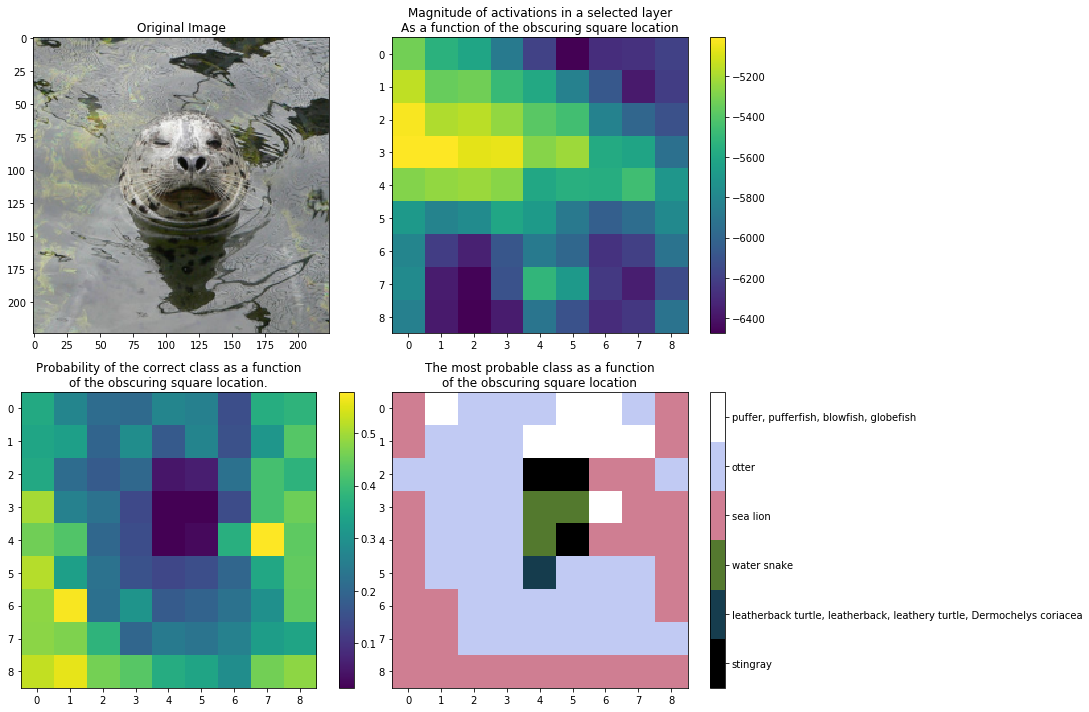

In [653]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

figure(figsize(16, 10))
subplot(2, 2, 1)
imshow(img)
title('Original Image')

subplot(2, 2, 2)
imshow(maps['heat'])
colorbar()
title('Magnitude of activations in a selected layer\n'
      'As a function of the obscuring square location')

subplot(2, 2, 3)
imshow(maps['prob'])
colorbar()
title('Probability of the correct class as a function\n'
      'of the obscuring square location.')


subplot(2, 2, 4)
discrete = np.zeros_like(maps['pred'], dtype=np.int64) #((maps['pred'].shape[0]), dtype=np.int32)
values = np.unique(maps['pred']).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps['pred'] == v)] = i
num_values = max(values.shape[0], 1)
imshow(discrete, cmap=discrete_cmap(num_values, 'cubehelix'))
cb = colorbar(ticks=np.arange((num_values-1.0)/num_values/2.0, num_values,
                              (num_values-1.0)/num_values))
cb.set_ticklabels([ilsvrc.id_to_desc[v] for v in values])
title('The most probable class as a function\n'
      'of the obscuring square location')


tight_layout()

## Method of [Integrated Gradients](https://arxiv.org/abs/1703.01365)

In [571]:
idx = 30
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx] 

predicted_id = to_np(vgg.predict(to_variable(img, volatile=True)))[0]

print ("Predicted: %s (correct: %s)" % (ilsvrc.id_to_desc[predicted_id],
                                        ilsvrc.label_to_desc[label]))

target = 0
desc = ilsvrc.label_to_desc[label]
for i, j in enumerate(ilsvrc.id_to_desc):
    if(j == desc):
        target = i

num_integration_points = 100

batch_size = 1

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype('float32')[:, None, None, None]
grads = []

for i in range(0, num_integration_points, batch_size):
    # batch contains a subset of images interpolating between the all gray image and the selected image
    batch = 0.5*(1.-i/num_integration_points) + img * i/num_integration_points
    
    batch = to_variable(batch, requires_grad=True)
    
    # Get the probabilities for the correct class
    prediction = vgg.probabilities(batch)[0,target]
    
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)

importance_scores = (np.sum(np.sum(abs(grads),axis=3),axis=0))

Predicted: cabbage butterfly (correct: cabbage butterfly)


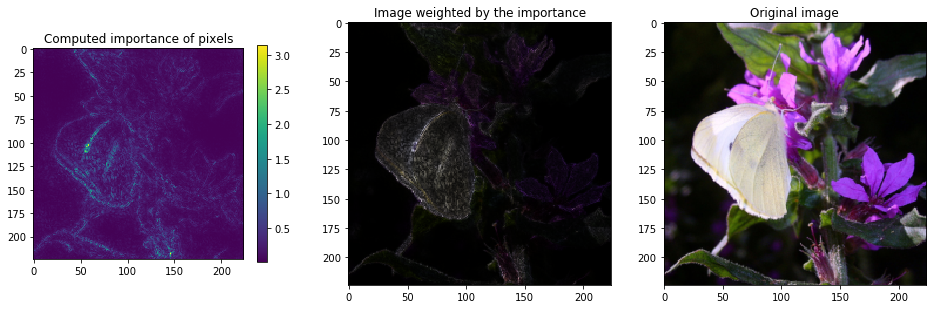

In [572]:
figsize(16, 10)
subplot(1,3,1)
imshow(importance_scores)
colorbar(shrink=0.4)
title('Computed importance of pixels')

subplot(1,3,2)
#normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7 # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:,:,None])
title('Image weighted by the importance')

subplot(1,3,3)
plt.imshow(img[0])
title('Original image')

# Reusing a VGG Network

* [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792)

* [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) 

In [625]:
# Get a fresh VGG network

vgg = VGG('vgg19')
#if CUDA:
#    vgg.cuda()

In [6]:
# List layers in the model
print ('Feature layers')
print ('--------------')
for name, layer in zip(vgg.feature_names, vgg.features):
    print ('{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1)))
print ('\nClassifier layers')
print ('-----------------')
for layer in vgg.classifier:
    print ('{: <12}({}'.format(*str(layer).split('(', 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_3   (inplace)
Conv2d      

In [627]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [628]:
if __name__ == "__main__":
    
    caltech_whole_dataset = torchvision.datasets.ImageFolder('C:/Users/opera_user/Anaconda3/Lib/site-packages/torchvision/datasets/101_ObjectCategories')
    
    all_indexes = np.random.permutation(len(caltech_whole_dataset))
    train_size = int(len(all_indexes) * 0.8)

    caltech_train_dataset = SubsampledImageDataset(
        caltech_whole_dataset,
        all_indexes[:train_size],
        torchvision.transforms.Compose([
            torchvision.transforms.RandomSizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]))

    caltech_test_dataset = SubsampledImageDataset(
        caltech_whole_dataset,
        all_indexes[train_size:],
        torchvision.transforms.Compose([
            torchvision.transforms.Scale(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]))

    caltech_datasets = {
        'train': caltech_train_dataset,
        'test': caltech_test_dataset,
    }
    
    
    
    
    imageRotate = lambda mI: mI.rotate(10 * np.random.uniform(-1,1))

    
    caltech_train_dataset_transform = SubsampledImageDataset(
        caltech_whole_dataset,
        all_indexes[:train_size],
        torchvision.transforms.Compose([
            torchvision.transforms.Lambda(imageRotate),
            torchvision.transforms.RandomSizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]))

    
    caltech_datasets_transform = {
        'train': caltech_train_dataset_transform,
        'test': caltech_test_dataset,
   

In [629]:
batch_size = 64
if __name__ == '__main__':
    caltech_loaders = {
        'train': torch.utils.data.DataLoader(
            caltech_datasets['train'], batch_size=batch_size,
            num_workers=0,
            shuffle=True),
        'test': torch.utils.data.DataLoader(
            caltech_datasets['test'], batch_size=batch_size,
            num_workers=0,
            shuffle=False)}


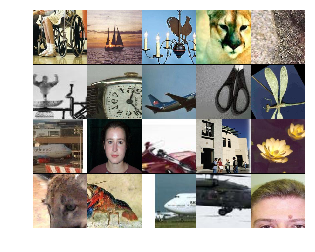

In [630]:
train_batch = next(iter(caltech_loaders['train']))
plotting.plot_mat(to_np(train_batch[0])[:20])

In [631]:
print ('\nClassifier layers')
print ('-----------------')
for layer in vgg.classifier:
    print ('{: <12}({}'.format(*str(layer).split('(', 1)))


Classifier layers
-----------------
Linear      (25088 -> 4096)
ReLU        (inplace)
Dropout     (p = 0.5)
Linear      (4096 -> 4096)
ReLU        (inplace)
Dropout     (p = 0.5)
Linear      (4096 -> 1000)


In [632]:
# Training code is based on assignment 4
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        x = Variable(x, volatile=True)
        y = Variable(y, volatile=True)
        outputs = model.forward(x)
        _, predictions = outputs.data.max(dim=1)
        num_errs += (predictions != y.data).sum()
        num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

        
def train(model, data_loaders, optimizer, num_epochs=1,
          log_every=100, cuda=True):
    if cuda:
        model.cuda()
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('You can interrupt it at any time.')
    try:
        while epoch < num_epochs:
            model.train()
            epoch += 1
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                # x = Variable(x.view(x.size(0), -1), requires_grad=False)
                x = Variable(x, requires_grad=False)
                y = Variable(y, requires_grad=False)
                
                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / out.size(0)

                history['train_losses'].append(loss.data[0])
                history['train_errs'].append(err_rate)

                if iter_ % log_every == 0:
                    print ("Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.data[0], err_rate))

            val_err_rate = compute_error_rate(model, data_loaders['test'], cuda)
            history['val_errs'].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                best_epoch = epoch
                best_val_err = val_err_rate
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print ('{0}\n{1}\n{0}'.format('-' * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print ("\nLoading best params on validation set (epoch %d)\n" %(best_epoch))
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()        

In [633]:
vgg.classifier

Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
  (2): Dropout (p = 0.5)
  (3): Linear (4096 -> 4096)
  (4): ReLU (inplace)
  (5): Dropout (p = 0.5)
  (6): Linear (4096 -> 1000)
)

In [48]:
affineLayer = nn.Linear(25088, 102)
affineLayer.weight.data.normal_(0,0.001)
affineLayer.bias.data.normal_(0,0.001)

classifier = nn.Sequential(affineLayer, nn.Softmax())

In [49]:
classifier

Sequential (
  (0): Linear (25088 -> 102)
  (1): Softmax ()
)

In [ ]:

affineLayer = nn.Linear(25088, 102)
affineLayer.weight.data.normal_(0,0.001)
affineLayer.bias.data.normal_(0,0.001)

classifier = nn.Sequential(affineLayer, nn.Softmax())

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = nn.NLLLoss()

# Train only the params of the classifier
optimizer = torch.optim.Adam(
    vgg.classifier.parameters(), lr=0.0001)

train(vgg, caltech_loaders, optimizer,
      num_epochs=10, log_every=1, cuda=False)

# A Neural Algorithm of Style

[A Neural Algorithm of Style](https://arxiv.org/abs/1508.06576),

In [115]:
img_dir = os.path.join(os.environ['PYTORCH_DATA_PATH'], 'images')

In [116]:
img_dir

'C:\\users\\opera_user\\Anaconda3\\Lib\\site-packages\\torchvision\\datasets\\images'

In [126]:
!dir $img_dir

 Volume in drive C has no label.
 Volume Serial Number is AA97-AF83

 Directory of C:\users\opera_user\Anaconda3\Lib\site-packages\torchvision\datasets\images

12/19/2017  06:46 PM    <DIR>          .
12/19/2017  06:46 PM    <DIR>          ..
12/19/2017  05:30 PM            60,725 bulwar.jpg
12/19/2017  05:27 PM           181,185 frida_kahlo.jpg
12/16/2017  10:13 PM            59,779 golden_gate.jpg
12/18/2017  06:05 PM           246,681 result.png
12/16/2017  10:11 PM            77,554 starry_night.jpg
12/19/2017  05:28 PM           170,463 starry_night_crop.png
12/19/2017  06:46 PM            46,411 wfa.jpg
12/19/2017  05:29 PM            31,444 wydzial.jpg
               8 File(s)        874,242 bytes
               2 Dir(s)  143,488,577,536 bytes free


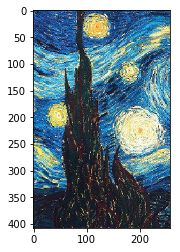

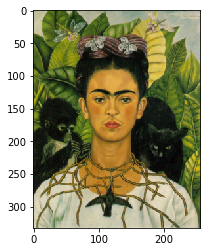

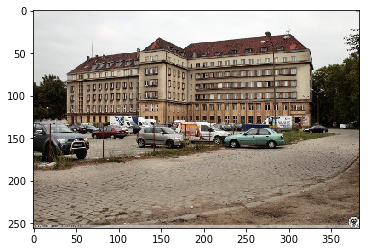

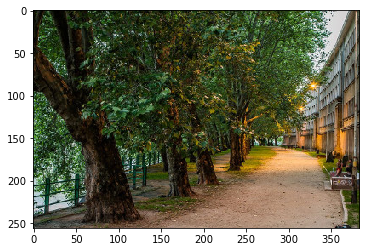

In [128]:
def load_image(path, size=256):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        img = torchvision.transforms.Scale(size)(img)
        return numpy.asarray(img).astype('float32') / 255.0

imshow(load_image(img_dir + '/starry_night_crop.png'))
plt.show()
imshow(load_image(img_dir + '/frida_kahlo.jpg'))
plt.show()
imshow(load_image(img_dir + '/wfa.jpg'))
plt.show()
imshow(load_image(img_dir + '/bulwar.jpg'))

In [110]:
class StyleTransferNet(object):
    def __init__(self, style_layers, content_layers, vgg_model='vgg19',
                 content_weight=5e0, style_weight=1e2):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()
        
    def capture_content(self, x):
        # implement saving naural activations for a chosen set of content layers
        self.content_captures = self.vgg.multi_layer_activations(x, self.content_layers)

        
    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(
            x, self.style_layers)
        self.style_captures = [self._gram_mat(l) for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        #print(needed_layers)
        needed_values = self.vgg.multi_layer_activations(
            x, needed_layers)
        content_values = needed_values[:len(self.content_layers)]
     
        style_values_w = needed_values[len(self.content_layers):]
        style_values = [self._gram_mat(l) for l in style_values_w]
        
        self.content_losses = [self.mse(a,b) for a,b in (zip(content_values, self.content_captures))]
        self.style_losses = [self.mse(a,b) for a,b in (zip(style_values, self.style_captures))]
        
        # append onto the lists  self.content_losses and self.style_losses 
        # the L2 (euclidean) distances between the captured statistics and the 
        # reconstructed image's ones. Remember about applying the gram matrix to style!
        
        loss = sum(self.content_losses) * self.content_weight
        loss += sum(self.style_losses) * self.style_weight
        
        return loss
            
    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        
        dims = x.size()
        y=x.view(dims[0],dims[1],dims[2]*dims[3])
        return (1.0/(dims[2]*dims[3]))*y.matmul(y.transpose(1,2))
 
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        #pass

In [133]:
model = StyleTransferNet(
    style_layers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1','conv5_1'],
    content_layers=['conv4_2'], content_weight=2e1)

#if CUDA:
#    model.vgg.cuda()

In [134]:
style_img_path = img_dir + '/frida_kahlo.jpg'
content_img_path = img_dir + '/bulwar.jpg'

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print ('Capturing content')
model.capture_content(to_variable(content_image))

print ('Capturing style')
model.capture_style(to_variable(style_image))

Capturing content
Capturing style


In [135]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_variable(image, requires_grad=True)

# try using Adam or LBFGS

#optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

Iteration     36 | loss 140.5750275


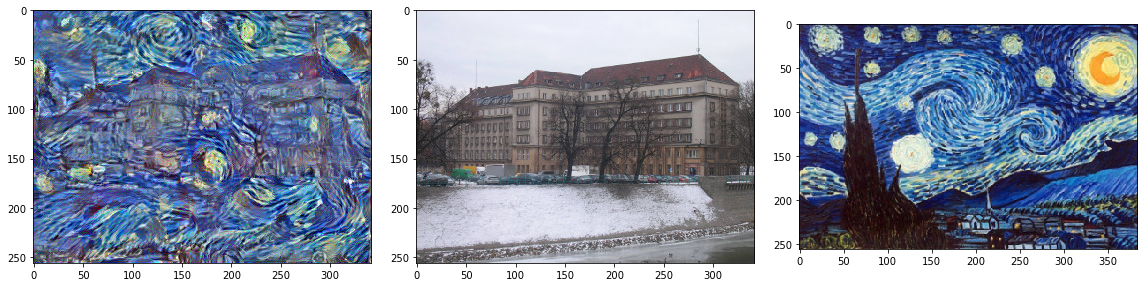

In [125]:
from IPython import display

# Training loop
max_iters = 101
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    fig.add_subplot(133).imshow(style_image)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image));
    for iter_ in range(max_iters):
        print(iter_)
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            #print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        loss = optimizer.step(closure)
        image.grad.data.zero_()
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print ("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0]))
            for i, l in enumerate(model.content_losses):
                print ('  Content loss {}: {: >8.4f}'.format(i + 1, l.data[0] * model.content_weight))
            for i, l in enumerate(model.style_losses):
                print ('  Style loss {}: {: >10.4f}'.format(i + 1, l.data[0] * model.style_weight))
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print ("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0]))

## With ommited content

Iteration     56 | loss 238.1413574


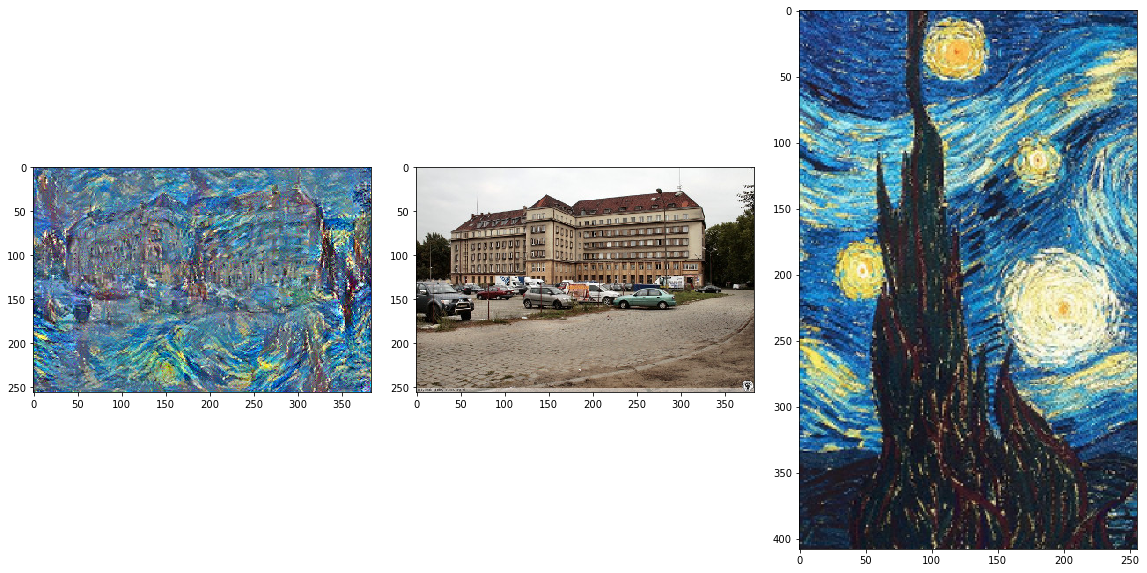

In [131]:
from IPython import display

# Training loop
max_iters = 101
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    fig.add_subplot(133).imshow(style_image)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image));
    for iter_ in range(max_iters):
        print(iter_)
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            #print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        loss = optimizer.step(closure)
        image.grad.data.zero_()
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print ("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0]))
            for i, l in enumerate(model.content_losses):
                print ('  Content loss {}: {: >8.4f}'.format(i + 1, l.data[0] * model.content_weight))
            for i, l in enumerate(model.style_losses):
                print ('  Style loss {}: {: >10.4f}'.format(i + 1, l.data[0] * model.style_weight))
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print ("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0]))

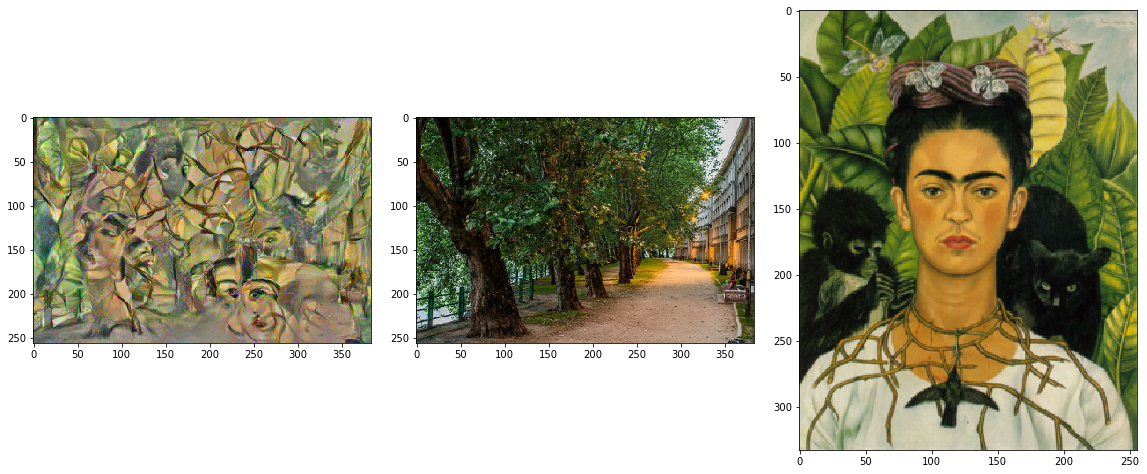

Iteration    100 | loss 251.8558655
  Content loss 1: 162.2878
  Style loss 1:     0.2952
  Style loss 2:     2.0321
  Style loss 3:     4.4904
  Style loss 4:    59.1091
  Style loss 5:    23.5813


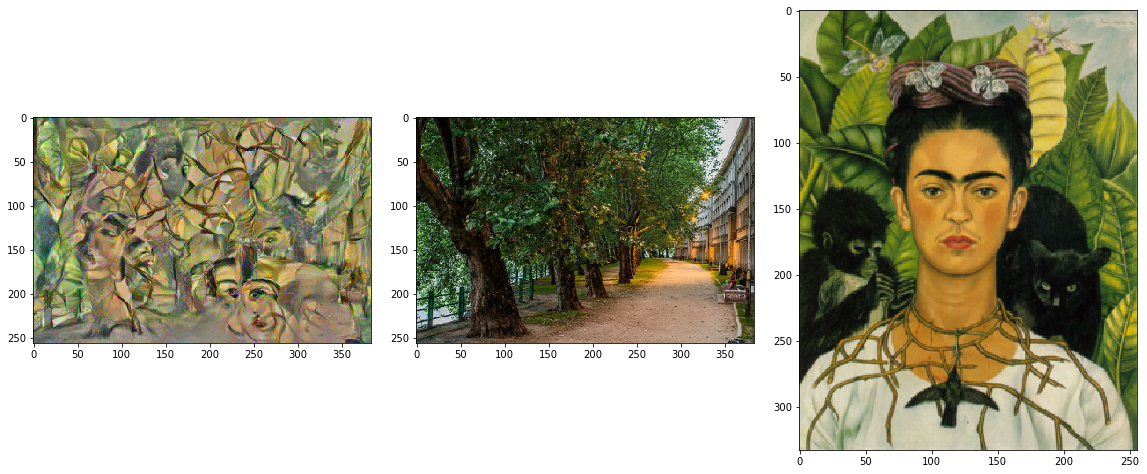

In [136]:
from IPython import display

# Training loop
max_iters = 101
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    fig.add_subplot(133).imshow(style_image)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image));
    for iter_ in range(max_iters):
        print(iter_)
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            #print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        loss = optimizer.step(closure)
        image.grad.data.zero_()
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print ("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0]))
            for i, l in enumerate(model.content_losses):
                print ('  Content loss {}: {: >8.4f}'.format(i + 1, l.data[0] * model.content_weight))
            for i, l in enumerate(model.style_losses):
                print ('  Style loss {}: {: >10.4f}'.format(i + 1, l.data[0] * model.style_weight))
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print ("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0]))